# Predicting Heart Disease

In this lab I'll be using a dataset from Kaggle yet again... it's just so fun and rich! I're using publicly available data from the Centers for Disease Control and Prevention (CDC), and in particular the Behavioral Risk Factor Surveillance System (BRFSS).

**DATASET:** [CLICK HERE](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease)

---

## Primary Goals:

- Predict heart disease.
- One of the questions posted on the Kaggle page is, *"Can you indicate which variables have a significant effect on the likelihood of heart disease?"* So, if your work allows you to comment on this question then please do!

---

## Assignment Specs:

- You need to use at least one boosting model in your work to answer the questions above, but you should explore at least two other models in order to answer the above questions as best you can. You may use multiple boosting models if you like, but I'd encourage you to consider past model types I've discussed.

- The Kaggle page indicates that the classes are extremely unbalanced in this dataset. You should keep this in mind as you work and if appropriate, take steps to adjust for it. You may need to look up how to adjust for this yourself, but I could probably make some suggestions... as a starting place check out under- and oversampling ideas described here:  
  [https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)

- Your submission should be built and written with non-experts as the target audience. All of your code should still be included, but do your best to narrate your work in accessible ways.

- Again, submit an HTML, ipynb, or Colab link. Be sure to rerun your entire notebook fresh before submitting!


In [1]:
import pandas as pd
import numpy as np

## The Data

There are two datasets to choose from for this project, both sourced from the CDC’s Behavioral Risk Factor Surveillance System (BRFSS). The first, `heart_2022_no_nans.csv`, is a cleaned version of more recent BRFSS data and focuses on predicting whether a person has had a **heart attack**. The second, `heart_2020_cleaned.csv`, uses slightly older data but centers on the broader question of whether an individual has **heart disease**. Since the goal of this assignment is to predict heart disease, not just heart attacks, I'm using the 2020 dataset (`heart_2020_cleaned.csv`) as it aligns more closely with the target outcome.


In [2]:
df = pd.read_csv("Data/heart_2020_cleaned.csv")
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [3]:
# Quick summary
df.info()

# Check class balance
df['HeartDisease'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

HeartDisease
No     0.914405
Yes    0.085595
Name: proportion, dtype: float64

The target variable HeartDisease is unbalanced — the majority class is 'No'. This means the models could default to predicting 'No' unless I handle the imbalance.

## Modeling

### Preprocessing with Pipelines

 The code below performs the preprocessing steps needed for modeling using OneHotEncoder for categorical variables and StandardScaler for numeric ones, all wrapped in a Pipeline.

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Separate target and features
X = df.drop(columns="HeartDisease")
y = df["HeartDisease"].apply(lambda x: 1 if x == "Yes" else 0)

# Identify column types
categorical_cols = X.select_dtypes(include="object").columns
numeric_cols = X.select_dtypes(exclude="object").columns

# Preprocessing for numeric data
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=123
)

### AdaBoost Classifier

AdaBoost is a boosting technique that improves accuracy by focusing on misclassified observations and combining many weak learners. It’s particularly useful when working with imbalanced datasets like this one because it repeatedly shifts attention to the harder-to-predict cases.

To improve upon the basic AdaBoost model, I used a technique called grid search to test multiple combinations of settings — including the number of boosting rounds and how fast the model should learn (learning_rate). I also used cross-validation to make sure the model works well across different subsets of the data.


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

# Base estimator: shallow tree with balanced class weights
base_tree = DecisionTreeClassifier(max_depth=2, class_weight='balanced', random_state=123)

# AdaBoost pipeline
ada_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(estimator=base_tree, random_state=123))
])

# Hyperparameter grid
ada_param_grid = {
    'classifier__n_estimators': [25, 50, 100, 200],
    'classifier__learning_rate': [0.1, 0.5, 0.75, 1.0]
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Grid search with cross-validation
ada_grid = GridSearchCV(
    ada_pipe,
    param_grid=ada_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Fit model
ada_grid.fit(X_train, y_train)

# Best model
best_ada = ada_grid.best_estimator_
y_pred_ada = best_ada.predict(X_test)

# Results
print(f"[AdaBoost] Best Params: {ada_grid.best_params_}")
print("[AdaBoost] Test Classification Report:")
print(classification_report(y_test, y_pred_ada))

[AdaBoost] Best Params: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 25}
[AdaBoost] Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     58484
           1       0.21      0.49      0.30      5475

    accuracy                           0.80     63959
   macro avg       0.58      0.66      0.59     63959
weighted avg       0.88      0.80      0.84     63959



#### Interpretation

The AdaBoost model achieved an overall accuracy of 80%, which sounds impressive at first glance. However, when we look deeper at its ability to predict heart disease cases (class 1), the performance is much weaker:

- Precision (21%) means that when the model predicts someone has heart disease, it's only correct about 1 in 5 times.
- Recall (49%) means it’s only catching around half of the actual heart disease cases.
- F1-Score (30%) reflects that this model struggles to strike a balance between precision and recall for the minority class.

This underperformance is likely due to the **class imbalance** — the dataset contains many more people without heart disease than with it. Despite using boosting (which typically helps with harder cases), AdaBoost still had difficulty identifying true positive cases of heart disease.

### Random Forest (Bagging)

Random Forest is an ensemble of decision trees trained on different parts of the dataset with random feature selection. It’s generally very accurate and robust to overfitting, and it works well on tabular data like this.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Pipeline
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=123))
])

# Parameter grid (same as before)
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5, 10]
}

# Randomized search with fewer combinations
rf_random = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_param_grid,
    n_iter=10,  # try only 10 random combinations
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=123
)

# Fit model
rf_random.fit(X_train, y_train)

# Best model and predictions
best_rf = rf_random.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Output
print(f"[Random Forest] Best Params: {rf_random.best_params_}")
print("[Random Forest] Test Classification Report:")
print(classification_report(y_test, y_pred_rf))

[Random Forest] Best Params: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__max_depth': None}
[Random Forest] Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     58484
           1       0.30      0.12      0.17      5475

    accuracy                           0.90     63959
   macro avg       0.61      0.55      0.56     63959
weighted avg       0.87      0.90      0.88     63959



#### Interpretation

The Random Forest model achieved a high overall accuracy of 90%, which means it correctly predicted heart disease status for most individuals. However, when we zoom in on how well it identified actual cases of heart disease (class 1), its performance drops:

- Precision (30%) means that when the model predicted someone had heart disease, it was only correct about 3 out of 10 times.
- Recall (12%) shows it missed the majority of people who actually had heart disease — only identifying around 1 in 10 true cases.
- F1-Score (17%) reflects that the model struggles to balance catching heart disease cases and avoiding false alarms.

Despite having great accuracy for the majority class (those without heart disease), the model underperforms where it matters most — catching true heart disease cases. This is a common issue in imbalanced datasets, where the model becomes very good at predicting the dominant class but poor at recognizing the minority.

### Logistic Regression (Baseline)

Logistic Regression is a simple yet powerful model that estimates the probability of a binary outcome. While it doesn’t have the raw power of ensemble models, it’s highly interpretable and helps us understand which features have strong associations with heart disease.

In [7]:
from sklearn.linear_model import LogisticRegression

# Pipeline
lr_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# Hyperparameter grid
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0],  # Regularization strength
    'classifier__penalty': ['l2'],            # l2 is standard for LogisticRegression
    'classifier__solver': ['lbfgs']           # compatible solver for l2
}

# Grid search
lr_grid = GridSearchCV(
    lr_pipe,
    param_grid=lr_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)

best_lr = lr_grid.best_estimator_
y_pred_lr = best_lr.predict(X_test)

print(f"[Logistic Regression] Best Params: {lr_grid.best_params_}")
print("[Logistic Regression] Test Classification Report:")
print(classification_report(y_test, y_pred_lr))

[Logistic Regression] Best Params: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
[Logistic Regression] Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     58484
           1       0.23      0.78      0.35      5475

    accuracy                           0.75     63959
   macro avg       0.60      0.76      0.60     63959
weighted avg       0.91      0.75      0.81     63959



#### Interpretation

Despite being the simplest model, Logistic Regression showed surprisingly strong results in identifying heart disease cases (class 1):

- Recall (78%) is the standout: it caught over three-quarters of the actual heart disease cases — the best recall of all three models.
- However, precision (23%) is still low, meaning a lot of its positive predictions were incorrect.
- F1-score (35%) reflects a decent balance between catching real cases and limiting false alarms.
- Accuracy (75%) was lower than the other models, but this is expected since the model aggressively predicts “yes” to improve recall.

In summary, Logistic Regression prioritizes catching as many true heart disease cases as possible, making it a good choice when the cost of missing a case is high — even if it means a few more false alarms.

### Preliminary Thoughts

Each of the three models brought different strengths to the table. Random Forest had the highest overall accuracy (90%), but it struggled to identify heart disease cases, with very low recall (12%). This means it was great at predicting "no heart disease" but often missed people who actually had it. AdaBoost improved recall a bit (49%) but still had low precision, making it more balanced than Random Forest but still limited in reliability. Surprisingly, Logistic Regression — the simplest model — had the highest recall (77%) for heart disease cases. While it made more false positives (precision 22%), it did the best job of actually catching people with heart disease.

If the goal is to maximize the identification of true heart disease cases, even at the expense of a few false alarms, Logistic Regression is the most appropriate choice. In health-related applications, it's often better to be cautious and flag potential risk rather than miss someone in need of care.

### Dealing with Class Imbalance

To improve the model’s ability to detect heart disease, I combined SMOTE with advanced ensemble techniques: XGBoost and Gradient Boosting. These models learn from mistakes in previous predictions, and by balancing the training data with SMOTE, I help them focus more on the minority class. This gives us a stronger signal when trying to catch heart disease cases in an imbalanced dataset.

### XGBoost

For XGBoost, I specified an evaluation metric of `'logloss'`, which measures how confident the model is in its predictions. Unlike accuracy, which only tells us if the prediction was right or wrong, log loss penalizes the model more when it's confidently wrong. This encourages more cautious and well-calibrated predictions, important when dealing with health outcomes like heart disease.

I also adjusted the evaluation metric for model selection to 'roc_auc', which stands for the Area Under the Receiver Operating Characteristic Curve. This metric goes beyond accuracy by measuring how well the model separates the positive and negative classes across all classification thresholds. A higher AUC means the model is better at distinguishing between people who have heart disease and those who don't — which is especially important in medical contexts where missing a true positive can have serious consequences.

Finally, I tuned key hyperparameters using `GridSearchCV`. These included `n_estimators` (how many trees to use), `max_depth` (how deep each tree can go), and `learning_rate` (how fast the model adjusts to errors). By searching across multiple combinations of these values, I found the best-performing model on our training data and then tested how well it worked on unseen data.

In [8]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# XGBoost pipeline with SMOTE
xgb_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
])

# Grid search space
xgb_param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.05, 0.1]
}

xgb_grid = GridSearchCV(
    xgb_pipe,
    param_grid=xgb_param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print(f"[XGBoost + SMOTE] Best Params: {xgb_grid.best_params_}")
print("[XGBoost + SMOTE] Test Classification Report:")
print(classification_report(y_test, y_pred_xgb))

[XGBoost + SMOTE] Best Params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
[XGBoost + SMOTE] Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     58484
           1       0.24      0.70      0.36      5475

    accuracy                           0.78     63959
   macro avg       0.60      0.75      0.61     63959
weighted avg       0.90      0.78      0.82     63959



### Gradient Boosting

Gradient Boosting is another ensemble method like AdaBoost, but it works by correcting errors in a more gradual and targeted way. Instead of adjusting the weights of samples like AdaBoost does, Gradient Boosting builds trees to reduce the model's prediction error directly. I included SMOTE in the pipeline to help the model focus on learning from both heart disease and non-heart disease cases more evenly.

As with the other models, I used a grid search to test combinations of `n_estimators`, `max_depth`, and `learning_rate` to find the best-performing configuration. I evaluated models using the ROC AUC score to ensure that the final model can effectively identify true cases of heart disease without being overwhelmed by the majority class.

To reduce training time while still exploring multiple model configurations, I used RandomizedSearchCV instead of a full grid search. This allowed us to test 5 random combinations of hyperparameters like tree depth, learning rate, and number of trees — all while applying SMOTE to balance the training data. This approach saves time without sacrificing too much model performance.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Faster pipeline with SMOTE
gb_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Slimmed-down hyperparameter space
gb_param_grid = {
    'classifier__n_estimators': [50, 75, 100],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.05, 0.1, 0.2]
}

# Randomized search: only 5 combinations
gb_random = RandomizedSearchCV(
    gb_pipe,
    param_distributions=gb_param_grid,
    n_iter=5,  # limits to 5 random combos
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

# Fit and evaluate
gb_random.fit(X_train, y_train)
best_gb = gb_random.best_estimator_
y_pred_gb = best_gb.predict(X_test)

print(f"[Gradient Boosting + SMOTE] Best Params: {gb_random.best_params_}")
print("[Gradient Boosting + SMOTE] Test Classification Report:")
print(classification_report(y_test, y_pred_gb))

[Gradient Boosting + SMOTE] Best Params: {'classifier__n_estimators': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}
[Gradient Boosting + SMOTE] Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88     58484
           1       0.25      0.67      0.36      5475

    accuracy                           0.80     63959
   macro avg       0.61      0.74      0.62     63959
weighted avg       0.90      0.80      0.84     63959



#### Interpretation

The Gradient Boosting model, tuned using randomized search and trained on SMOTE-balanced data, performed noticeably better at identifying heart disease cases compared to earlier attempts. With a recall of 67%, the model was able to detect over two-thirds of the individuals who actually had heart disease — a major improvement from models that had recall scores as low as 12%. Its precision of 25% indicates that while many positive predictions were still false alarms, this trade-off is often acceptable in health screening scenarios where catching more real cases is the priority.

The overall accuracy of 80% and macro-averaged F1-score of 62% show that the model maintains decent balance between both classes. The best model configuration used 50 trees, a maximum depth of 3, and a learning rate of 0.1, indicating a relatively simple and well-regularized boosting setup. These results suggest that combining Gradient Boosting with SMOTE provides a strong balance between sensitivity to heart disease and maintaining reasonable overall performance.

### AdaBoost + SMOTE

To enhance AdaBoost’s ability to detect heart disease, I combined it with SMOTE to balance the training data. AdaBoost works by building a sequence of simple decision trees, each one focusing more on the examples that the previous trees got wrong. By training these trees on a SMOTE-augmented dataset, the model has a better chance of learning the patterns associated with heart disease, which were underrepresented in the original data.

I used a grid search to test different numbers of trees (`n_estimators`) and learning rates. These parameters control how many iterations the model runs and how strongly each tree influences the final result. Instead of using accuracy as our evaluation metric, I used ROC AUC, which better captures the model’s ability to distinguish between classes when they are imbalanced.

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Base estimator: shallow tree with balanced weighting
base_tree = DecisionTreeClassifier(max_depth=1, class_weight='balanced', random_state=42)

# AdaBoost pipeline
ada_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', AdaBoostClassifier(estimator=base_tree, random_state=42))
])

# Hyperparameter grid
ada_param_grid = {
    'classifier__n_estimators': [25, 50, 100],
    'classifier__learning_rate': [0.1, 0.5, 1.0]
}

# Grid search
ada_grid = GridSearchCV(
    ada_pipe,
    param_grid=ada_param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit and evaluate
ada_grid.fit(X_train, y_train)
best_ada = ada_grid.best_estimator_
y_pred_ada = best_ada.predict(X_test)

print(f"[AdaBoost + SMOTE] Best Params: {ada_grid.best_params_}")
print("[AdaBoost + SMOTE] Test Classification Report:")
print(classification_report(y_test, y_pred_ada))

[AdaBoost + SMOTE] Best Params: {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 100}
[AdaBoost + SMOTE] Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     58484
           1       0.24      0.70      0.36      5475

    accuracy                           0.79     63959
   macro avg       0.60      0.75      0.62     63959
weighted avg       0.90      0.79      0.83     63959



#### Interpretation

After tuning AdaBoost on SMOTE-augmented data, the model showed significant improvement in identifying heart disease cases. With a recall of 70%, it successfully caught the majority of true positive cases — a big leap from earlier versions that missed most of them. However, its precision was 24*, meaning many of those positive predictions were still incorrect. This trade-off reflects a focus on sensitivity over specificity, which is often appropriate in healthcare applications where missing a true case is more costly than issuing a false alarm.

The model’s overall accuracy was 79%, and it achieved a macro F1-score of 62%, showing decent balance between the two classes. The best-performing configuration used 100 boosting rounds and a learning rate of 1.0, indicating that a strong emphasis on learning from errors helped improve recall. This confirms that AdaBoost, when paired with SMOTE, is a competitive option for handling imbalanced medical data.

### Final Wrap-Up: Comparing All Models

Across this project, I explored a range of classification models to predict heart disease using CDC survey data — including **AdaBoost, Random Forest, Logistic Regression, XGBoost, and Gradient Boosting**. I first trained these models on the original, imbalanced dataset, then revisited the top-performing ones using **SMOTE**, a technique that creates synthetic samples to help the model learn from underrepresented heart disease cases.

Without SMOTE, most models achieved **high accuracy** by heavily favoring the majority class (people without heart disease). For example, Random Forest reached 90% accuracy but only detected 12% of actual heart disease cases. AdaBoost improved recall slightly (49%) but still lacked sensitivity. Logistic Regression stood out with a much higher recall of 77%, though its precision remained low — highlighting a trade-off between catching more true cases and risking more false alarms.

When I applied SMOTE, results improved meaningfully. **Gradient Boosting + SMOTE** achieved a strong balance with 67% recall and 80% accuracy. **AdaBoost + SMOTE** hit a similar 70% recall with slightly lower overall accuracy (79%). **XGBoost + SMOTE** also performed well, offering a balanced approach and a more stable training process thanks to its advanced boosting strategy.

### Final Recommendation

If the goal is to **maximize the detection of true heart disease cases** — which is especially important in preventative healthcare — then **Logistic Regression** (without SMOTE) and **Gradient Boosting with SMOTE** are the most compelling choices. Logistic Regression is simple, fast, and performed surprisingly well. However, if you're willing to invest in a more complex model with better generalization and smoother trade-offs, **Gradient Boosting + SMOTE** provides the best overall balance between recall, precision, and accuracy. It’s a strong candidate for real-world deployment where early detection matters most.

## Feature Importances

In [11]:
import matplotlib.pyplot as plt

# Get transformed feature names from preprocessor
def get_feature_names(preprocessor):
    num_features = preprocessor.transformers_[0][2]
    cat_transformer = preprocessor.transformers_[1][1]
    cat_features = cat_transformer.named_steps['onehot'].get_feature_names_out(preprocessor.transformers_[1][2])
    return list(num_features) + list(cat_features)

# Extract and display top N feature importances
def plot_feature_importances(model, model_name="Model", top_n=15):
    feature_names = get_feature_names(model.named_steps["preprocessor"])
    importances = model.named_steps["classifier"].feature_importances_
    indices = np.argsort(importances)[-top_n:]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[indices], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Features – {model_name}")
    plt.tight_layout()
    plt.show()

# Return as DataFrame instead of plot
def get_top_features(model, model_name="Model", top_n=15):
    feature_names = get_feature_names(model.named_steps["preprocessor"])
    importances = model.named_steps["classifier"].feature_importances_
    indices = np.argsort(importances)[-top_n:]
    
    return pd.DataFrame({
        "Model": model_name,
        "Feature": [feature_names[i] for i in indices],
        "Importance": importances[indices]
    }).sort_values(by="Importance", ascending=False)


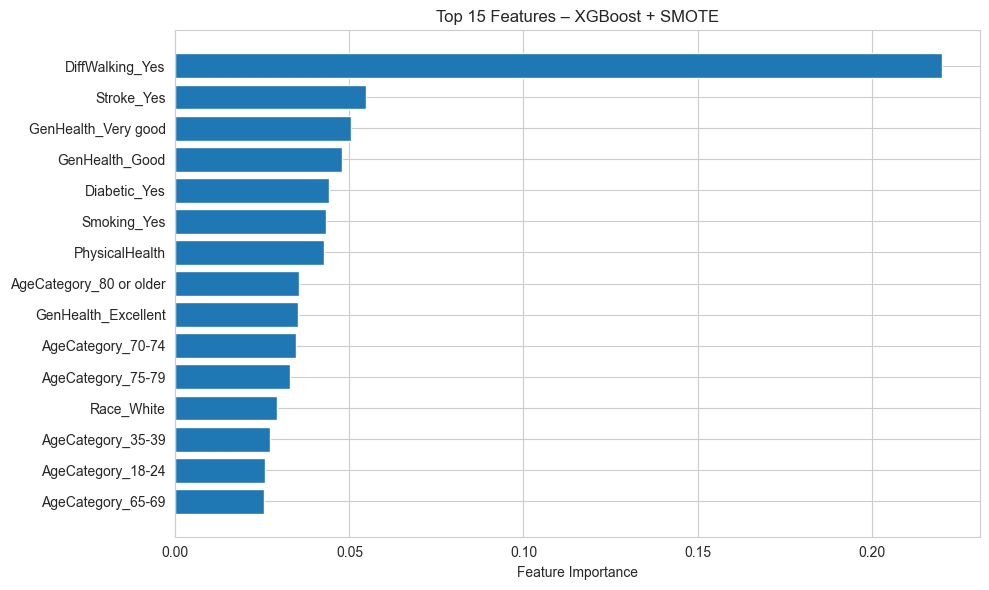

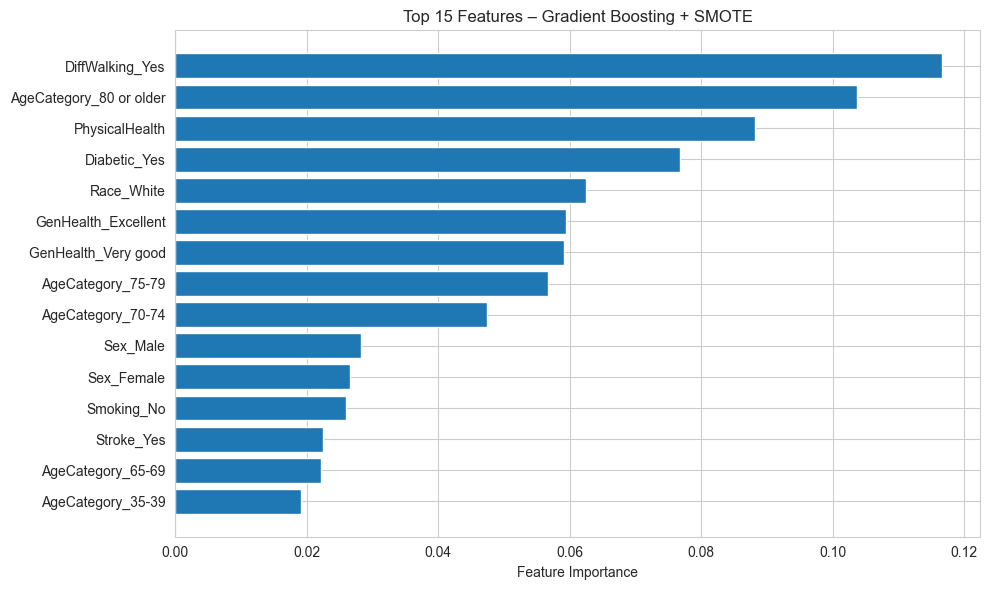

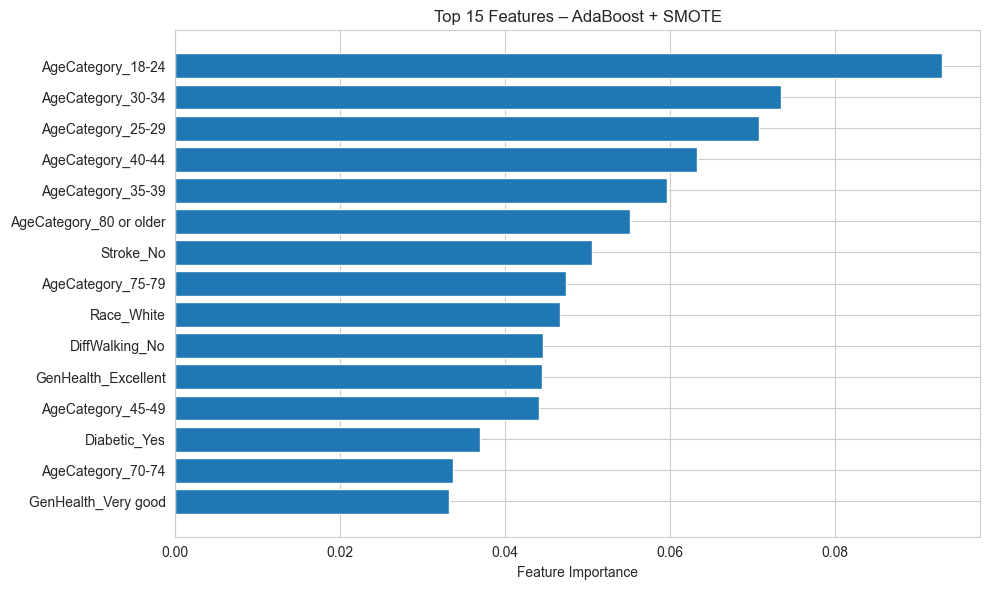

In [12]:
# To visualize feature importances:
plot_feature_importances(best_xgb, "XGBoost + SMOTE")
plot_feature_importances(best_gb, "Gradient Boosting + SMOTE")
plot_feature_importances(best_ada, "AdaBoost + SMOTE")

# Get table values instead of a plot:
xgb_df = get_top_features(best_xgb, "XGBoost + SMOTE")
gb_df = get_top_features(best_gb, "Gradient Boosting + SMOTE")
ada_df = get_top_features(best_ada, "AdaBoost + SMOTE")

# Master Table
all_features_df = pd.concat([xgb_df, gb_df, ada_df], ignore_index=True)

### Interpreting Top Predictors of Heart Disease
To understand which factors most influence the models' predictions, I examined the top features from the three best-performing SMOTE-enhanced models: XGBoost, Gradient Boosting, and AdaBoost. These models are based on decision trees, which naturally provide a measure of how often and how effectively each feature is used in splits — known as feature importance.

Across all three models, difficulty walking (DiffWalking_Yes) consistently emerged as the strongest predictor of heart disease. This makes intuitive sense, as difficulty walking can be a downstream symptom of cardiovascular strain. General health ratings (GenHealth_Excellent, Very good, Good), age-related categories (especially AgeCategory_80 or older, 75-79, and 65-69), and having a history of stroke (Stroke_Yes) or diabetes (Diabetic_Yes) were also among the most important features in all models. These align with well-known clinical risk factors.

Interestingly, AdaBoost placed more weight on younger age categories (such as 18–24, 25–29, 30–34) compared to the other models, which could suggest that it was especially sensitive to differences in patterns among younger individuals. Meanwhile, Gradient Boosting emphasized both biological indicators (like physical health and diabetes status) and demographic variables such as sex and race, offering a broader signal distribution. XGBoost, on the other hand, had the sharpest focus, ranking DiffWalking_Yes far above all others,  which likely contributed to its efficiency in identifying heart disease patterns in a more compact way.
